In [1]:
import numpy as np
from sklearn import metrics
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision import models, datasets
import torchvision.transforms as transforms
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt

In [2]:
print(f"Is GPU available? {torch.cuda.is_available()}")
print(f"Number of available devices: {torch.cuda.device_count()}")
print(f"Index of current device: {torch.cuda.current_device()}")
print(f"Device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

Is GPU available? True
Number of available devices: 1
Index of current device: 0
Device name: NVIDIA GeForce RTX 4050 Laptop GPU


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# writer = SummaryWriter('runs/experiment_55')

BATCH_SIZE = 512
N_EPOCHS = 10
LEARNING_RATE = 0.001

# Nacitanie dat

In [4]:
from scipy.io import loadmat
from sklearn.model_selection import train_test_split

class notMNIST(Dataset):
    def __init__(self, data, labels):
        self.images = data
        self.labels = labels

        self.transformation = transforms.Compose([
                                                  
            transforms.ToTensor(),
            transforms.ConvertImageDtype(dtype=torch.float32),
        ])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        img = self.images[index]
        label = self.labels[index]
        img_tensor = self.transformation(img)
        y_tensor = torch.tensor(label, dtype=torch.long)
        return img_tensor.view(1, 28, 28), y_tensor


data = loadmat('notMNIST_small.mat')
print(data.keys())

images = data['images']
labels = data['labels']

print(images.shape)
images = [images[:, :, i] for i in range(0, images.shape[2])]
images = np.asarray(images)
print(images.shape)
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, shuffle=True)

train_dataset = notMNIST(x_train, y_train)
test_dataset = notMNIST(x_test, y_test)

trainloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

dict_keys(['__header__', '__version__', '__globals__', 'images', 'labels'])
(28, 28, 18724)
(18724, 28, 28)


# MLP Siet

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128,10),
            nn.Softmax()
        )

    def forward(self, x):
        out = x.view(x.shape[0], -1)
        out = self.fc_layers(out)
        return out


# CNN Siet

In [5]:
class CustomCNN(torch.nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(10, 20, kernel_size=5),
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(320, 100),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(100, 10),
            nn.Softmax()
        )

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = out.view(x.shape[0], -1)
        out = self.fc_layers(out)
        return out
    



In [ ]:
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__
        

# Resnet18

In [ ]:
model = models.resnet18(pretrained=False)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc.out_features = 10
print(model.named_children)

# count = 0
# freeze_first_n_layers = 4
# # freeze backbone layers
# for param in model.children(): 
#     if count < freeze_first_n_layers and len(list(param.parameters())) > 0: # freezing first 3 layers
#         print(param)
#         param.requires_grad_(False)
#         count +=1      


# Trenovanie

In [6]:
model = CustomCNN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

model = model.to(device)

model.train()

acc_history = []
loss_history = []
final_labels = []
final_predicted = []

for epoch in trange(1, N_EPOCHS + 1, desc="1st loop"):
    epoch_loss = 0
    n_batches = len(train_dataset) // BATCH_SIZE
    correct = 0
    total = 0
    accuracy_train = 0

    for step, (images, labels) in enumerate(tqdm(trainloader, desc="Epoch {}/{}".format(epoch, N_EPOCHS))):

        images = images.to(device)
        labels = labels.to(device)
        
        # Dopredne sirenie, 
        # ziskame pravdepodobnosti tried tym, ze posleme do modelu vstupy
        outputs = model(images)

        # Vypocitame chybu algoritmu       
        loss = criterion(outputs, labels)
        
        # Uspesnost algoritmu
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy_train = correct / total
        epoch_loss += loss.item() 
        
        # Je vhodne zavolat zero_grad() pred zavolanim spatneho sirenia 
        # pre vynulovanie gradientov z predosleho volania loss.backward()
        optimizer.zero_grad()

        # Spatne sirenie chyby, vypocitaju sa gradienty
        loss.backward()
        
        # Aktualizacia vah pomocou optimalizatora
        optimizer.step()

        if step % n_batches == 0 and step != 0:
            epoch_loss = epoch_loss / n_batches

            # writer.add_scalar(
            #     'training loss',
            #     epoch_loss,
            #     epoch
            # )

            acc_history.append(accuracy_train)
            loss_history.append(epoch_loss)
            print("Epoch {}, Loss {:.6f}, Accuracy {:.2f}% ".format(epoch, epoch_loss, accuracy_train * 100))
            epoch_loss = 0

            #print(model.layer1[0].conv1.weight[0][0])
            #print(model.layer2[0].conv1.weight[0][0])
            #print(model.layer3[0].conv1.weight[0][0])

        final_predicted += predicted.tolist()
        final_labels += labels.tolist()
        torch.cuda.empty_cache()



# writer.add_hparams(
#     {
#     'optimizer': optimizer.__class__.__name__,
#     'lr': LEARNING_RATE, 
#     'batch_size': BATCH_SIZE
#     },
#     {
#     'hparam/train/accuracy': accuracy_train,
#     }
# )
# writer.close()

1st loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/30 [00:00<?, ?it/s]

C:\Users\marti\AppData\Local\Temp\ipykernel_14812\2383397833.py:22: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y_tensor = torch.tensor(label, dtype=torch.long)
c:\Users\marti\miniconda3\envs\win-torch\lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 1, Loss 2.044503, Accuracy 58.71% 


Epoch 2/10:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 2, Loss 1.711097, Accuracy 83.93% 


Epoch 3/10:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 3, Loss 1.651510, Accuracy 88.11% 


Epoch 4/10:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 4, Loss 1.629455, Accuracy 89.76% 


Epoch 5/10:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 5, Loss 1.614684, Accuracy 90.77% 


Epoch 6/10:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 6, Loss 1.605374, Accuracy 91.59% 


Epoch 7/10:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 7, Loss 1.600946, Accuracy 92.18% 


Epoch 8/10:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 8, Loss 1.594796, Accuracy 92.66% 


Epoch 9/10:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 9, Loss 1.589402, Accuracy 93.19% 


Epoch 10/10:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 10, Loss 1.584758, Accuracy 93.51% 


# Ukladanie modelu

In [ ]:
PATH = "./model.pt"
torch.save(model.state_dict(), PATH)

# Nacitanie modelu

In [ ]:
model = None
model = MLP()
model.load_state_dict(torch.load(PATH))
print(model)

# Priebeh trenovania

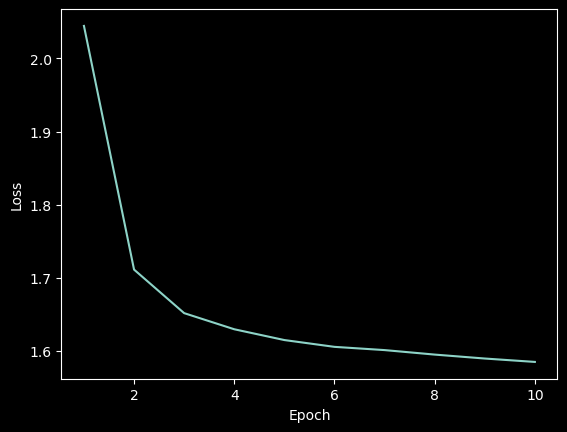

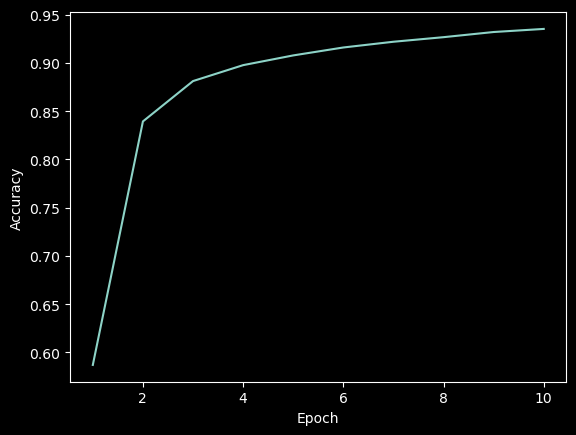

In [7]:
plt.plot(np.array(range(1, N_EPOCHS + 1)), loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(np.array(range(1, N_EPOCHS + 1)), acc_history)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Testovanie modelu

In [8]:
model.eval()  # activate evaulation mode, some layers behave differently
use_cuda = torch.cuda.is_available()
if use_cuda:
    model.cuda()
total = 0
correct = 0
final_labels = []
final_predicted = []
for inputs, labels in tqdm(iter(testloader), desc="Full forward pass", total=len(testloader)):
    if use_cuda:
        inputs = inputs.cuda()
        labels = labels.cuda()
    with torch.no_grad():
        outputs_batch = model(inputs)

    _, predicted = torch.max(outputs_batch.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    final_predicted += predicted.tolist()
    final_labels += labels.tolist()

print('Accuracy of the network on the test images: %0.2f %%' % (100 * correct / total))

Full forward pass:   0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\marti\AppData\Local\Temp\ipykernel_14812\2383397833.py:22: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y_tensor = torch.tensor(label, dtype=torch.long)


Accuracy of the network on the test images: 92.79 %


# Zobrazenie filtrov

In [9]:
from torchvision import utils

def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
  n,c,w,h = tensor.shape

  if allkernels: tensor = tensor.view(n*c, -1, w, h)
  elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

  rows = np.min((tensor.shape[0] // nrow + 1, 64))    
  grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
  plt.figure( figsize=(nrow,rows) )
  plt.imshow(grid.numpy().transpose((1, 2, 0)))


filter = model.layer1[0].conv1.weight.data.clone().cpu()
# print(filter)
visTensor(filter, ch=0, allkernels=False)

AttributeError: 'CustomCNN' object has no attribute 'layer1'

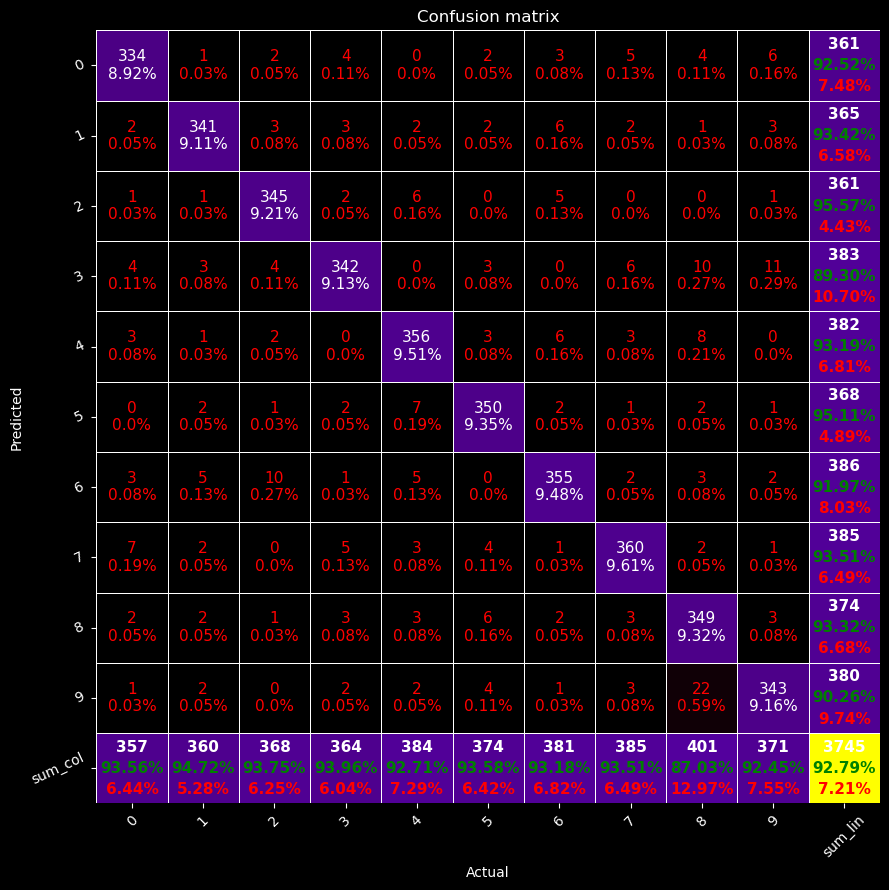

In [10]:
from pretty_confusion_matrix import pp_matrix_from_data

y_test = final_labels
predic =  final_predicted

labels = [i for i in range(10)]

pp_matrix_from_data(y_test, predic, columns=labels, cmap="gnuplot")

# Vizualizacia vystupu siete

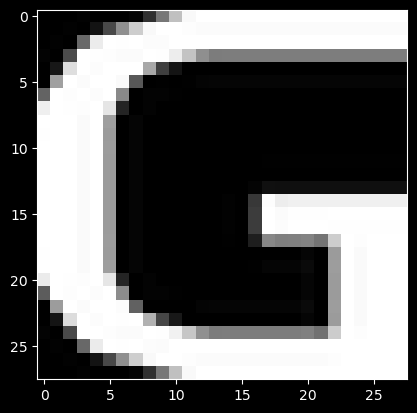

Predicted label: [6] | True label: 6


In [38]:
sel = np.random.randint(0,len(y_test))
x = x_test[sel,:,:]

plt.imshow(x, cmap='gray')
plt.show()

model_in = torch.tensor(x, dtype=torch.float32).view(1,1,28,28).to(device)

with torch.no_grad():
    output = model(model_in)

_, predicted = torch.max(output.data, 1)


print(f"Predicted label: {predicted.cpu().numpy()} | True label: {y_test[sel]}")

In [ ]:
import pickle

with open('runs/cnn3/train_metrics.pkl', 'rb') as f:
    loaded = pickle.load(f)